# 19-05-16 Notes:
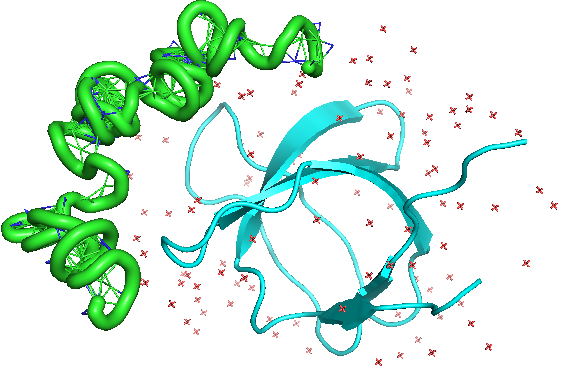
I was attempting to generate PDB files for my model's predictions (including sidechains), but I found out that my backbone reconstruction is poor to begin with. In this notebook, I'll use `prody` and `matplotlib` to try to root out the issue.  

In [50]:
from prody import *
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
sys.path.extend(['../transformer/'])
from Sidechains import SC_DATA
# from pylab import *
# %matplotlib inline  
%matplotlib notebook
# %pylab
np.set_printoptions(suppress=True)

In [51]:
from numpy import sign, tile, concatenate, pi, cross, subtract, round, var
from numpy import ndarray, power, sqrt, array, zeros, arccos
RAD2DEG = 180 / pi

## Load true and predicted structures

In [95]:
true = parsePDB("1Y0M", chain="A").select('protein and name N CA C')
gen = parsePDB("../coords/0516a/1Y0M_A_l0.00.pdb")
# true = parsePDB("1h75", chain="A").select('protein and name N CA C')
# gen = parsePDB("../coords/0516a/1H75_A_l0.00.pdb")
true, gen

(<Selection: 'protein and name N CA C' from 1Y0MA (183 atoms)>,
 <AtomGroup: 1Y0M_A_l0.00 (183 atoms)>)

<IPython.core.display.Javascript object>


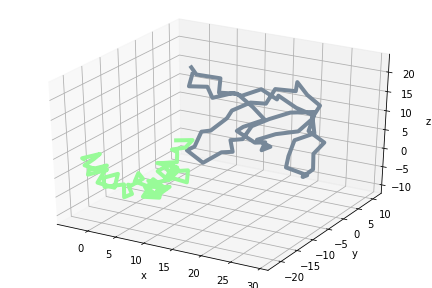

In [96]:
showProtein(true, gen)

## Do the dihedrals match the true structure?

In [97]:
def get_dihedral(coords1, coords2, coords3, coords4, radian=False):
    """Return the dihedral angle in degrees."""

    a1 = coords2 - coords1
    a2 = coords3 - coords2
    a3 = coords4 - coords3

    v1 = cross(a1, a2)
    v1 = v1 / (v1 * v1).sum(-1)**0.5
    v2 = cross(a2, a3)
    v2 = v2 / (v2 * v2).sum(-1)**0.5
    porm = sign((v1 * a3).sum(-1))
    rad = arccos((v1*v2).sum(-1) / ((v1**2).sum(-1) * (v2**2).sum(-1))**0.5)
    if radian:
        return porm * rad
    else:
        return porm * rad * RAD2DEG

In [98]:
true.getNames()[:5], gen.getNames()[:5]

(array(['N', 'CA', 'C', 'N', 'CA'], dtype='<U6'),
 array(['N', 'CA', 'C', 'N', 'CA'], dtype='<U6'))

In [99]:
true.ca.getResnames()[:5], gen.ca.getResnames()[:5]

(array(['THR', 'PHE', 'LYS', 'SER', 'ALA'], dtype='<U6'),
 array(['THR', 'PHE', 'LYS', 'SER', 'ALA'], dtype='<U6'))

In [100]:
t_coords = true.getCoords()
g_coords = gen.getCoords()
i = 0
coords = ["N", "CA", "C"]*500
while i < len(true) - 3:
    a, b, c, d = t_coords[i], t_coords[i+1], t_coords[i+2], t_coords[i+3]
    w, x, y, z = g_coords[i], g_coords[i+1], g_coords[i+2], g_coords[i+3]
    t_dihe = get_dihedral(a, b, c, d, radian=True)
    g_dihe = get_dihedral(w, x, y, z, radian=True)
    print(coords[i : (i+4)], t_dihe - g_dihe)
    print(t_dihe, g_dihe)
    i += 1
# Looking to see if using calcDihedral vs get_dihedral returns anything different
# i = 0
# coords = ["N", "CA", "C"]*500
# while i < len(true) - 3:
#     a, b, c, d = true[i], true[i+1], true[i+2], true[i+3]
#     w, x, y, z = gen[i], gen[i+1], gen[i+2], gen[i+3]
#     t_dihe = calcDihedral(a, b, c, d, radian=True)
#     g_dihe = calcDihedral(w, x, y, z, radian=True)
#     d = t_dihe - g_dihe
#     print(coords[i : (i+4)], d, d + 2 * pi, d + pi, d - pi)
#     print(t_dihe, g_dihe)
#     i += 1

['N', 'CA', 'C', 'N'] 0.0003229649171901383
-0.2716121117710285 -0.27193507668821865
['CA', 'C', 'N', 'CA'] -0.24746628002858895
-3.0308256049959765 -2.7833593249673876
['C', 'N', 'CA', 'C'] -3.1056691779273438
-1.2909792189483824 1.8146899589789613
['N', 'CA', 'C', 'N'] 0.00039239404841939773
2.058792992294031 2.0584005982456115
['CA', 'C', 'N', 'CA'] -5.102830015120944
-3.114189714072131 1.9886403010488123
['C', 'N', 'CA', 'C'] -2.1813255149166877
-1.898937774395728 0.2823877405209597
['N', 'CA', 'C', 'N'] 2.8739196188620753e-05
2.57009868763371 2.5700699484375216
['CA', 'C', 'N', 'CA'] 0.9996305641408283
2.9987631212944694 1.9991325571536411
['C', 'N', 'CA', 'C'] -1.9654974983057951
-2.505636907133765 -0.5401394088279698
['N', 'CA', 'C', 'N'] 0.0016004847950465972
1.4283340546142724 1.4267335698192258
['CA', 'C', 'N', 'CA'] -5.237166720503717
-3.071435196676476 2.1657315238272417
['C', 'N', 'CA', 'C'] -2.4963055117788984
-2.0020790443057312 0.4942264674731671
['N', 'CA', 'C', 'N'] 0

In [101]:
list(true.getHierView())[0]

<Chain: A from 1Y0MA (61 residues, 183 atoms)>

In [102]:
for tres, gres in zip(list(true.getHierView())[0].iterResidues(), 
                      list(gen.getHierView())[0].iterResidues()):
    try: 
        phi = calcPhi(tres, radian=True) - calcPhi(gres, radian=True)
        gphi = calcPhi(gres, radian=True)
        tphi = calcPhi(tres, radian=True)
    except ValueError:
        gphi = -999
        phi = -999
        tphi = -999
    try:
        psi = calcPsi(tres, radian=True) - calcPsi(gres, radian=True)
        gpsi = calcPsi(gres, radian=True)
        tpsi = calcPsi(tres, radian=True)
    except ValueError:
        gpsi = -999
        psi = -999
        tpsi = -999
    try:
        omega = calcOmega(tres, radian=True) - calcOmega(gres, radian=True)
        gomega = calcOmega(gres, radian=True)
        tomega = calcOmega(tres, radian=True)
    except ValueError:
        gomega = -999
        omega = -999
        tomega = -999
#     print("{0}: {1:.2f} {2:.2f} {3:.2f}".format(tres, phi, psi, omega))
    print("{0}: {1:.2f} {2:.2f} {3:.2f}".format(tres, tphi, tpsi, tomega))

THR 791: -999.00 -0.27 -3.03
PHE 792: -1.29 2.06 -3.11
LYS 793: -1.90 2.57 3.00
SER 794: -2.51 1.43 -3.07
ALA 795: -2.00 2.60 3.05
VAL 796: -2.33 2.69 3.10
LYS 797: -1.93 2.21 3.12
ALA 798: -1.16 2.27 3.03
LEU 799: -1.68 -0.27 -3.10
PHE 800: -2.51 2.66 3.01
ASP 801: -1.17 2.64 2.99
TYR 802: -2.52 2.18 3.03
LYS 803: -1.70 2.14 3.09
ALA 804: -0.89 2.32 3.09
GLN 805: -1.89 -0.27 3.11
ARG 806: -2.27 2.82 -2.99
GLU 807: -1.11 -0.54 -3.10
ASP 808: -1.69 0.36 -3.13
GLU 809: -1.86 2.70 -3.13
LEU 810: -1.52 2.57 2.91
THR 811: -1.97 2.35 3.08
PHE 812: -2.69 2.92 3.06
THR 813: -1.96 2.74 2.97
LYS 814: -0.79 2.38 3.10
SER 815: 1.54 -0.17 3.05
ALA 816: -1.04 2.51 3.03
ILE 817: -1.78 2.02 -3.14
ILE 818: -1.79 2.28 -2.93
GLN 819: -2.01 2.80 3.07
ASN 820: 0.97 0.83 -3.00
VAL 821: -1.44 2.20 2.93
GLU 822: -1.65 2.17 -3.06
LYS 823: -1.77 2.16 3.04
GLN 824: -2.19 2.77 -2.95
ASP 825: -1.73 0.30 3.03
GLY 826: -1.71 0.32 3.14
GLY 827: 1.54 0.00 -3.07
TRP 828: -2.28 2.22 3.08
TRP 829: -2.03 2.89 3.06
ARG 830

In [ ]:
import prody as pr
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
sys.path.extend(['../transformer/'])
from Sidechains import SC_DATA
%matplotlib inline

In [ ]:
SC_DATA["ARG"]

In [ ]:
refs_fns = glob("../data/amino_acid_substructures/*.pdb")

In [ ]:
refs = pr.parsePDB(refs_fns)

In [ ]:
refs[0].getCoords(), refs[0].getNames()